**@Dieine Bernieri Schiavon<p>
UFCSPA - Universidade Federal de Ciências da Saúde de Porto Alegre<p>
Informática Biomédica <p>
dieineb@ufcspa.edu.br** <p>
https://github.com/dieineb <p>
**13/09/2022**

# Usando rede pré-treinada
Uma abordagem comum e altamente eficaz para aprendizado profundo em pequenos conjuntos de dados de imagem é usar uma rede pré-treinada. Uma rede pré-treinada é uma rede salva que foi previamente treinada em um grande conjunto de dados, normalmente em uma tarefa de classificação de imagem em grande escala. Se este
conjunto de dados original é grande o suficiente e geral o suficiente, então a hierarquia espacial dos recursos aprendidos pela rede pré-treinada pode efetivamente atuar como um modelo genérico do mundo visual e, portanto, seus recursos podem ser úteis para muitos problemas diferentes de visão computacional, mesmo embora esses novos problemas possam envolver classes completamente diferentes daquelas da tarefa original. Por exemplo, você pode treinar uma rede no ImageNet (onde as classes são principalmente animais e objetos do cotidiano) e então redirecionar essa rede treinada para algo tão remoto quanto identificar itens de móveis em
imagens. Essa portabilidade de recursos aprendidos em diferentes problemas é uma vantagem importante do aprendizado profundo em comparação com muitas abordagens antigas de aprendizado superficial, e
torna o aprendizado profundo muito eficaz para problemas de dados pequenos.
 Nesse caso, vamos considerar um grande convnet treinado no conjunto de dados ImageNet
(1,4 milhão de imagens rotuladas e 1.000 classes diferentes). O ImageNet contém muitas classes de animais, incluindo diferentes espécies de cães e gatos, e você pode esperar um bom desempenho no problema de classificação de cães versus gatos.
 Você usará a arquitetura VGG16, desenvolvida por Karen Simonyan e Andrew
Zisserman em 2014; é uma arquitetura convnet simples e amplamente usada para ImageNet.1
Embora seja um modelo mais antigo, longe do estado da arte atual e um pouco
mais pesado do que muitos outros modelos recentes, eu o escolhi porque sua arquitetura é semelhante
o que você já conhece e é fácil de entender sem introduzir nenhum
novos conceitos. Este pode ser seu primeiro encontro com um desses modelos fofos
nomes — VGG, ResNet, Inception, Inception-ResNet, Xception e assim por diante; você terá
acostumado com eles, porque eles aparecerão com frequência se você continuar fazendo aprendizado profundo
para visão computacional.
**Há duas maneiras de usar uma rede pré-treinada: extração de recursos e ajuste fino.
Nós cobriremos os dois. Vamos começar com a extração de recursos.**

# Extração de recursos/características:
A extração de recursos consiste em usar as representações aprendidas por uma rede anterior
para extrair recursos interessantes de novas amostras. Esses recursos são então executados por meio de um novo classificador, que é treinado do zero.

Como você viu anteriormente, as convnets usadas para classificação de imagens compreendem duas partes: elas começam com uma série de camadas de agrupamento e convolução e terminam com um classificador densamente conectado. A primeira parte é chamada de base convolucional do modelo. No caso de convnets, a extração de recursos consiste em pegar a base convolucional de uma rede previamente treinada, executar os novos dados através dela e treinar um novo classificador em cima da saída.<p>

Por que apenas reutilizar a base convolucional? Você poderia reutilizar o classificador densamente conectado também? Em geral, isso deve ser evitado. A razão é que as representações aprendidas pela base convolucional provavelmente serão mais genéricas e, portanto, mais reutilizáveis: os mapas de características de uma rede são mapas de presença de conceitos genéricos sobre uma imagem, o que provavelmente será útil independentemente do computador -problema de visão na mão. Mas as representações aprendidas pelo classificador serão necessariamente específicas ao conjunto de classes em que o modelo foi treinado - elas conterão apenas informações sobre a probabilidade de presença desta ou daquela classe em todo o quadro. Além disso, as representações encontradas em camadas densamente conectadas não contêm mais nenhuma informação sobre onde os objetos estão localizados na imagem de entrada: essas camadas eliminam a noção de espaço, enquanto a localização do objeto ainda é descrita por mapas de características convolucionais. Para problemas em que a localização do objeto é importante, recursos densamente conectados são amplamente inúteis.

Observe que o nível de generalidade (e, portanto, de reutilização) das representações extraídas por camadas de convolução específicas depende da profundidade da camada no modelo. As camadas anteriores no modelo extraem mapas de recursos locais e altamente genéricos (como arestas visuais, cores e texturas), enquanto as camadas superiores
extrair conceitos mais abstratos (como “orelha de gato” ou “olho de cachorro”). Portanto, se seu novo conjunto de dados for muito diferente do conjunto de dados no qual o modelo original foi treinado, talvez seja melhor usar apenas as primeiras camadas do modelo para fazer a extração de recursos, em vez de usar toda a base convolucional.
    
Nesse caso, como o conjunto de classes do ImageNet contém várias classes de cães e gatos, é provável que seja benéfico reutilizar as informações contidas nas camadas densamente conectadas do modelo original. Mas escolheremos não, para cobrir o caso mais geral em que o conjunto de classes do novo problema não se sobrepõe ao conjunto de classes do problema.
modelo original. Vamos colocar isso em prática usando a base convolucional da rede VGG16, treinada no ImageNet, para extrair recursos interessantes de imagens de gatos e cachorros e, em seguida, treinar um classificador de cães contra gatos em cima desses recursos.
    
O modelo VGG16, entre outros, vem pré-embalado com Keras. Você pode importá-lo do módulo keras.applications. Aqui está a lista de modelos de classificação de imagem (todos pré-treinados no conjunto de dados ImageNet) que estão disponíveis como parte do keras
.formulários: <p>
 **Xception** <p>
 **Inception V3**<p>
 **ResNet50**<p>
 **VGG16**<p>
 **VGG19**<p>
 **MobileNet**
  
 

# Let’s instantiate the VGG16 model

Passamos três argumentos para o construtor: <p> **weights** especifica o ponto de verificação de peso a partir do qual inicializar o modelo.<p>  **include_top** refere-se a incluir (ou não) o classificador densamente conectado em topo da rede. Por padrão, esse classificador densamente conectado corresponde a as 1.000 classes do ImageNet. Porque pretendemos usar nossos próprios densamente classificador conectado (com apenas duas classes: gato e cachorro), não precisamos incluí-lo.<p>  **input_shape** é a forma dos tensores de imagem que alimentaremos a rede. Este argumento é puramente opcional: se não o passarmos, a rede poderá processar entradas de qualquer tamanho. Aqui o passamos para que possamos visualizar (no resumo a seguir) como o tamanho dos mapas de recursos diminui a cada nova convolução e camada de agrupamento. Aqui está o detalhe da arquitetura da base convolucional VGG16:

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import tensorflow as tf
import keras as ke
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
conv_base = ke.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False,
 input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

O mapa de recursos final tem forma (4, 4, 512).Esse é o recurso sobre o qual você colocará um classificador densamente conectado.
  Neste ponto, existem duas maneiras de prosseguir:<p>
 Executando a base convolucional em seu conjunto de dados, gravando sua saída em um array Numpy no disco e, em seguida, usando esses dados como entrada para um classificador autônomo e densamente conectado semelhante aos que você viu na parte 1 deste livro. Essa solução é rápida e barata de executar, porque requer apenas a execução da base convolucional uma vez para cada imagem de entrada, e a base convolucional é de longe a parte mais cara do pipeline. Mas, pelo mesmo motivo, essa técnica não permitirá que você use o aumento de dados.<p>

 Estendendo o modelo que você tem (conv_base) adicionando camadas Densas no topo e
executando a coisa toda de ponta a ponta nos dados de entrada. Isso permitirá que você use
aumento de dados, porque cada imagem de entrada passa pela base convolucional
cada vez que é visto pelo modelo. Mas pela mesma razão, esta técnica é
muito mais cara que a primeira.
    
Abordaremos ambas as técnicas. Vamos percorrer o código necessário para configurar o primeiro
um: gravando a saída de conv_base em seus dados e usando essas saídas como
entradas para um novo modelo.


# EXTRAÇÃO RÁPIDA DE CARACTERÍSTICAS/RECURSOS SEM AUMENTO DE DADOS
Você começará executando instâncias do ImageDataGenerator introduzido anteriormente para extrair imagens como matrizes Numpy, bem como seus rótulos. Você extrairá recursos dessas imagens chamando o método de previsão do modelo conv_base.

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/gdrive/MyDrive/Model/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20


In [8]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in  generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

#As extrações estão atualmente na forma (amostras, 4, 4, 512).
#Você irá alimentá-los para um classificador densamente conectado, então primeiro você deve achatá-los para (amostras, 8192):
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Neste ponto, você pode definir seu classificador densamente conectado (observe o uso de dropout para regularização) e treiná-lo nos dados e rótulos que você acabou de gravar:

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics = ["acc"])

history = model.fit(train_features, train_labels,
epochs=30,
batch_size=20,
validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 18ms/step - loss: 0.5044 - acc: 0.7870 - val_loss: 0.2841 - val_acc: 0.8820
Epoch 2/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2551 - acc: 0.8960 - val_loss: 0.2955 - val_acc: 0.8670
Epoch 3/30
100/100 [==============================] - 2s 16ms/step - loss: 0.2045 - acc: 0.9170 - val_loss: 0.2362 - val_acc: 0.9010
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.1645 - acc: 0.9345 - val_loss: 0.2486 - val_acc: 0.8920
Epoch 5/30
100/100 [==============================] - 2s 16ms/step - loss: 0.1475 - acc: 0.9445 - val_loss: 0.2447 - val_acc: 0.8990
Epoch 6/30
100/100 [==============================] - 2s 16ms/step - loss: 0.1298 - acc: 0.9485 - val_loss: 0.2845 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 2s 15ms/step - loss: 0.1015 - acc: 0.9610 - val_loss: 0.3304 - val_acc: 0.8790
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

**O treinamento é muito rápido, porque você só precisa lidar com duas camadas Densas - uma época leva segundos, mesmo na CPU.**

# Plotando os resultados

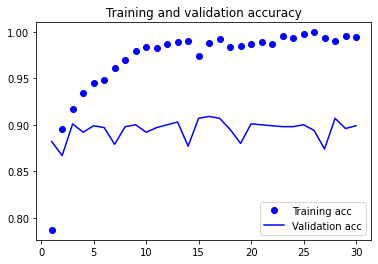

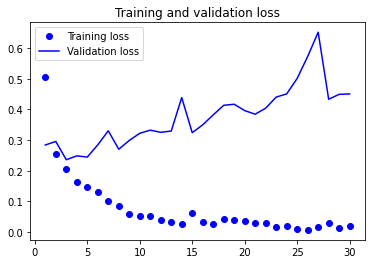

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Outra forma de plotar os mesmos resultados

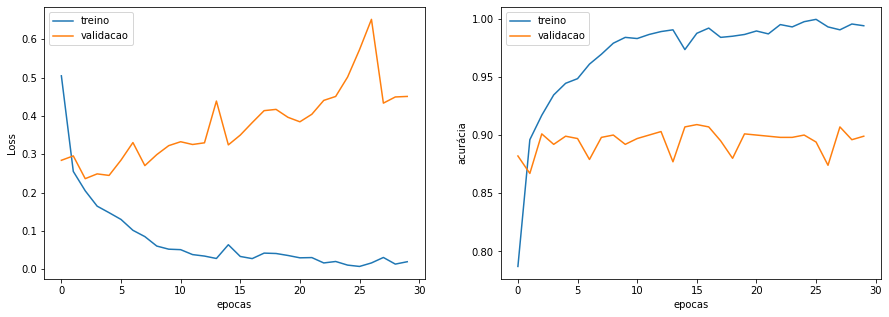

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("Loss")

plt.legend();
plt.subplot(1,2,2)
plt.plot(history.history["acc"], label="treino")
plt.plot(history.history["val_acc"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia")

plt.legend();

Você alcança uma precisão de validação de cerca de 90% - muito melhor do que você alcançou no exemplo anterior **(DogsXCats_Chollet)** com o pequeno modelo treinado do zero. Mas os gráficos também indicam que você está superajustando (overfitting) quase desde o início – apesar de usar dropout com uma taxa bastante grande (0.50 = 50%). Isso porque essa técnica não usa aumento de dados, o que é essencial para evitar **overfitting com pequenos conjuntos de dados de imagem**. <p>
**EXTRAÇÃO DE RECURSOS COM AUMENTO DE DADOS**
Agora, vamos revisar a segunda técnica para fazer extração de recursos, que é muito mais lenta e cara, mas que permite usar o aumento de dados durante o treinamento: estender o modelo conv_base e executá-lo de ponta a ponta
as entradas.<p>
**OBSERVAÇÃO** Essa técnica é tão cara que você só deve tentar se tiver acesso a uma GPU - é absolutamente intratável na CPU. Se você não pode executar seu código na GPU, a técnica anterior é o caminho a seguir.
Como os modelos se comportam exatamente como camadas, você pode adicionar um modelo (como conv_base) a um modelo Sequencial da mesma forma que adicionaria uma camada.

# Adicionando um classificador densamente conectado no topo da base convolucional

In [13]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Como você pode ver, a base convolucional do VGG16 possui 14.714.688 parâmetros, o que é muito grande. O classificador que você está adicionando no topo tem 2 milhões de parâmetros.
  Antes de compilar e treinar o modelo, é muito importante congelar a base convolucional. Congelar uma camada ou conjunto de camadas significa evitar que seus pesos sejam atualizados durante o treinamento. Se você não fizer isso, as representações que foram aprendidas anteriormente pela base convolucional serão modificadas durante o treinamento. Porque
as camadas Densas no topo são inicializadas aleatoriamente, atualizações de peso muito grandes seriam propagadas pela rede, destruindo efetivamente as representações aprendidas anteriormente.
  No Keras, você congela uma rede definindo seu atributo treinável como False:

In [14]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


Com esta configuração, apenas os pesos das duas camadas Densas que você adicionou serão treinados. Isso é um total de quatro tensores de peso: dois por camada (a matriz de peso principal e o vetor de polarização). Observe que, para que essas alterações tenham efeito, você deve primeiro compilar o modelo. Se você modificar a capacidade de treinamento de peso após a compilação, deve recompilar o modelo ou essas alterações serão ignoradas.
  Agora você pode começar a treinar seu modelo, com a mesma configuração de aumento de dados usada no exemplo anterior.

# Treinando o modelo de ponta a ponta com uma base convolucional congelada

In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(optimizer = 'adam' , 
              loss = "binary_crossentropy", metrics = ["acc"])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 680s 7s/step - loss: 0.5919 - acc: 0.7280 - val_loss: 0.3504 - val_acc: 0.8410
Epoch 2/30
100/100 [==============================] - 670s 7s/step - loss: 0.3859 - acc: 0.8185 - val_loss: 0.2651 - val_acc: 0.8950
Epoch 3/30
100/100 [==============================] - 668s 7s/step - loss: 0.3674 - acc: 0.8275 - val_loss: 0.3301 - val_acc: 0.8500
Epoch 4/30
100/100 [==============================] - 667s 7s/step - loss: 0.3419 - acc: 0.8425 - val_loss: 0.2638 - val_acc: 0.8940
Epoch 5/30
100/100 [==============================] - 668s 7s/step - loss: 0.3294 - acc: 0.8560 - val_loss: 0.2604 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 670s 7s/step - loss: 0.3385 - acc: 0.8505 - val_loss: 0.2461 - val_acc: 0.8990
Epoch 7/30
100/100 [==============================] - 671s 7s/step - loss: 0.3106 - acc: 0.8655 - val_loss: 0.3065 - v

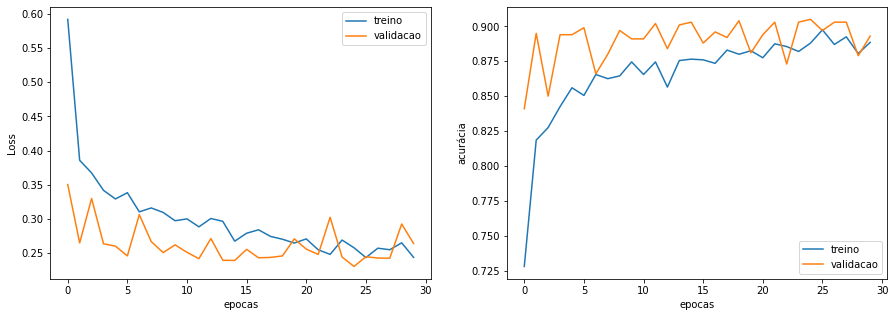

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("Loss")
plt.legend();
plt.subplot(1,2,2)
plt.plot(history.history["acc"], label="treino")
plt.plot(history.history["val_acc"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia")
plt.legend();

# Fine-tuning
Outra técnica amplamente utilizada para reutilização de modelos, complementar à extração de recursos, é o ajuste fino. O ajuste fino consiste em descongelar algumas das camadas superiores de uma base de modelo congelada usada para extração de recursos e treinar conjuntamente a parte recém-adicionada do modelo (neste caso, o classificador totalmente conectado) e essas camadas superiores. Isso é chamado de ajuste fino porque ajusta levemente as representações mais abstratas do modelo que está sendo reutilizado, a fim de torná-las mais relevantes para o problema em questão.

Afirmei anteriormente que é necessário congelar a base de convolução do VGG16 para poder treinar um classificador inicializado aleatoriamente no topo. Pela mesma razão, só é possível ajustar as camadas superiores da base convolucional depois que o classificador no topo já tiver sido treinado. Se o classificador ainda não estiver treinado, o sinal de erro que se propaga pela rede durante o treinamento será muito grande e as representações previamente aprendidas pelas camadas que estão sendo ajustadas serão destruídas. Assim, as etapas para ajustar uma rede são as seguintes:<p>
1 Adicione sua rede personalizada em cima de uma rede base já treinada.<p>
2 Congele a rede base.<p>
3 Treine a parte que você adicionou.<p>
4 Descongele algumas camadas na rede base.<p>
5 Treine em conjunto ambas as camadas e a parte que você adicionou.<p>
Você já concluiu as três primeiras etapas ao fazer a extração de recursos. Vamos prosseguir com o passo 4: você irá descongelar seu conv_base e então congelar camadas individuais
dentro dele.<p>
 Como lembrete, é assim que sua base convolucional se parece:

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Você ajustará as últimas três camadas convolucionais, o que significa que todas as camadas até
block4_pool deve ser congelado e as camadas block5_conv1, block5_conv2 e
block5_conv3 deve ser treinável.
 Por que não ajustar mais camadas? Por que não ajustar toda a base convolucional?
Você poderia. Mas você precisa considerar o seguinte:<p>
 Camadas anteriores na base convolucional codificam recursos mais genéricos e reutilizáveis,
enquanto as camadas superiores codificam recursos mais especializados. É mais útil para
ajustar os recursos mais especializados, porque estes são os que precisam
ser reaproveitado em seu novo problema. Haveria retornos decrescentes rápidos em
ajuste fino das camadas inferiores.<p>
 Quanto mais parâmetros você está treinando, maior o risco de overfitting.
A base convolucional tem 15 milhões de parâmetros, então seria arriscado
tente treiná-lo em seu pequeno conjunto de dados.<p>
Assim, nesta situação, é uma boa estratégia ajustar apenas as duas ou três camadas superiores
na base convolucional. Vamos configurar isso, começando de onde você parou no exemplo anterior.

# congelando todas as camadas até uma específica

In [26]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
else:
    layer.trainable = False

Agora você pode começar a ajustar a rede. Você fará isso com o otimizador RMSProp/Adam, usando uma taxa de aprendizado muito baixa. A razão para usar uma taxa de aprendizado baixa é que você deseja limitar a magnitude das modificações feitas nas representações das três camadas que você está ajustando. Atualizações muito grandes podem prejudicar essas representações.

# Modo Fine-Tuning

In [ ]:
model.compile(optimizer = 'adam' , 
              loss = "binary_crossentropy", metrics = ["acc"])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100, # Exemplo do livro - Não consegui rodas as 100 épocas mesmo no Colab pro - encerrou a execução após 16h (30 épocas foram executadas nesse período) . Tentei antes 30 épocas e consegui plotar os resultados anteriores.
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 1867s 19s/step - loss: 7.3056 - acc: 0.5105 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 1846s 18s/step - loss: 0.6936 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/100
100/100 [==============================] - 1888s 19s/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/100
100/100 [==============================] - 1842s 18s/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/100
100/100 [==============================] - 1840s 18s/step - loss: 0.6932 - acc: 0.4910 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/100
100/100 [==============================] - 1840s 18s/step - loss: 0.6932 - acc: 0.4830 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/100
100/100 [==============================] - 1844s 18s/step - loss: 0.6932 - acc: 0.4890 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/100
100/100 [===========================

# Plotando

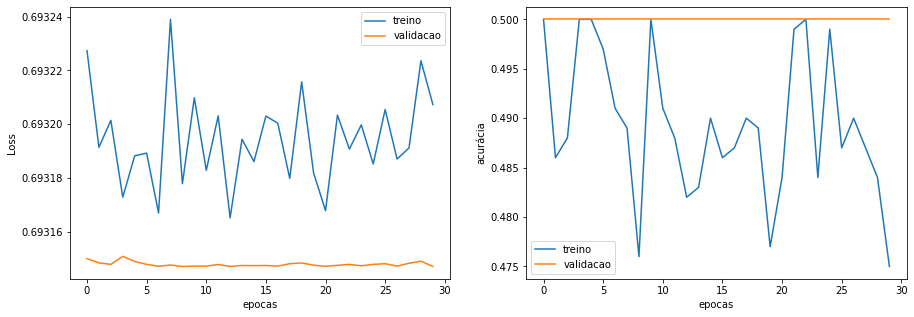

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,2)
plt.plot(history.history["acc"], label="treino")
plt.plot(history.history["val_acc"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("acurácia")
plt.legend();

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="treino")
plt.plot(history.history["val_loss"], label="validacao")
plt.xlabel("epocas")
plt.ylabel("Loss")
plt.legend();

Essas curvas parecem ruidosas. Para torná-las mais legíveis, você pode suavizá-las substituindo cada perda e precisão por médias móveis exponenciais dessas quantidades. Aqui está uma função de utilidade trivial para fazer isso:

# Suavizando (Smoothing)

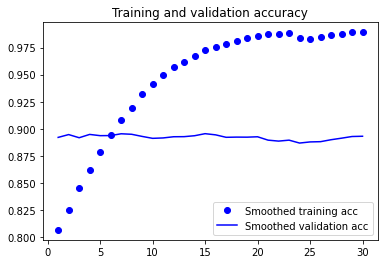

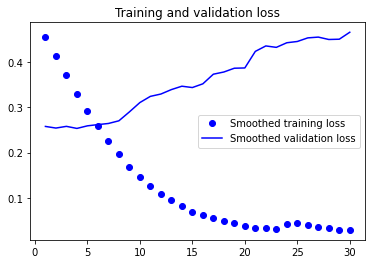

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

A curva de precisão de validação parece muito mais limpa. Você está vendo uma boa melhoria absoluta de 1% na precisão, de cerca de 96% para mais de 97%.<p>
  Observe que a curva de perda não mostra nenhuma melhora real (na verdade, está se deteriorando). Você pode se perguntar, como a precisão pode permanecer estável ou melhorar se a perda não for
diminuindo? A resposta é simples: o que você exibe é uma média dos valores de perda pontual; mas o que importa para a precisão é a distribuição dos valores de perda, não sua média, porque a precisão é o resultado de um limiar binário da probabilidade de classe previsto pelo modelo. O modelo ainda pode estar melhorando, mesmo que isso não se reflita na perda média.<p>
  Agora você pode finalmente avaliar esse modelo nos dados de teste:

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 53s 1s/step - loss: 0.6931 - acc: 0.5000
test acc: 0.5


Aqui você obtém uma precisão de teste de 97%. Na competição original do Kaggle em torno deste
conjunto de dados, este teria sido um dos principais resultados. Mas usando técnicas modernas de aprendizado profundo, você conseguiu chegar a esse resultado usando apenas uma pequena fração dos dados de treinamento disponíveis (cerca de 10%). Há uma enorme diferença entre poder treinar em 20.000 amostras e com 2.000 amostras!

**Referências:**<p>

Livro: Deep Learning With Python [François Chollet, 2018]<p>

Capítulo 4 - Fundamentals of machine learning<p>

Capítulo 5 - Deep Learning for computer vision<p>

Dataset: www.kaggle.com/c/dogs-vs-cats/data